# ARIMA Model - Complete Guide to Time Series Forecasting in Python
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

## Introduction to ARIMA Models

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

## What does the p, d and q in ARIMA model mean

Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

So how to make a series stationary?

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

Next, what are the ‘p’ and ‘q’ terms?

‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors. And ‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

## What are AR and MA models

So what are AR and MA models? What is the actual mathematical formula for the AR and MA models?

A pure Auto Regressive (AR only) model is one where Yt depends only on its own lags. That is, Yt is a function of the ‘lags of Yt’.

Likewise a pure Moving Average (MA only) model is one where Yt depends only on the lagged forecast errors.

So what does the equation of an ARIMA model look like?

An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms.

ARIMA model in words:

_Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)_

The objective, therefore, is to identify the values of p, d and q.

## How to find the order of differencing (d) in ARIMA model

The purpose of differencing it to make the time series stationary.

But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

So how to determine the right order of differencing?

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv('../input/wwwusage.csv', names=['value'], header=0)
df.head()

,value
0,88
1,84
2,85
3,85
4,84


First, check if the series is stationary using the **Augmented Dickey Fuller test**, from the statsmodels package.

In [28]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.value.dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


Since P-value is greater than the significance level, let’s **difference the series** and see how the **autocorrelation plot** looks like.

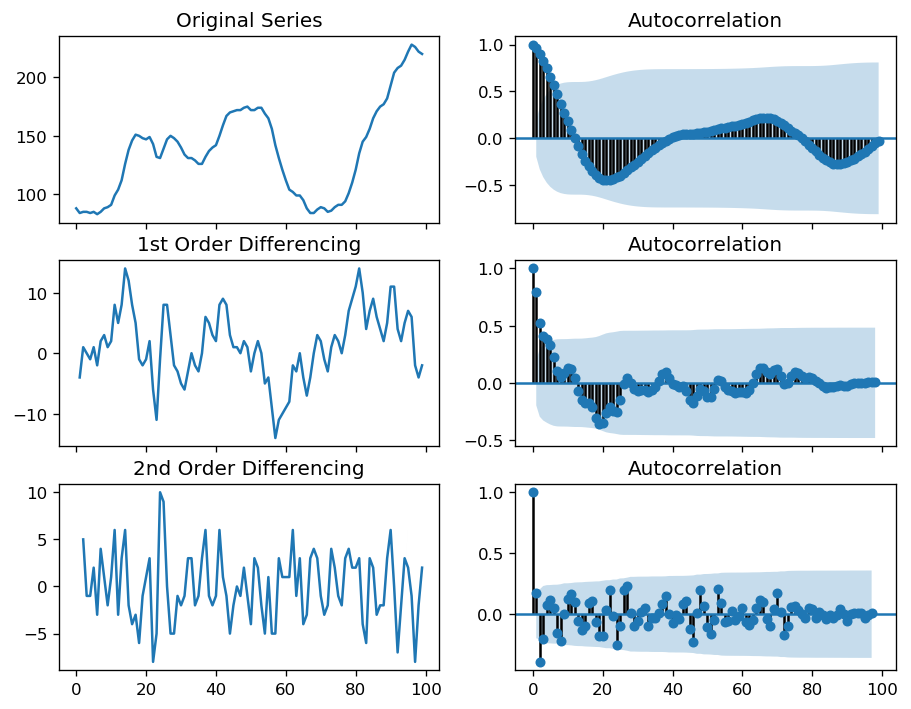

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

In [30]:
from pmdarima.arima.utils import ndiffs

y = df.value

## Adf Test
print('adf:', ndiffs(y, test='adf')) # 2

# KPSS test
print('kpss:', ndiffs(y, test='kpss')) # 0

# PP test:
print('pp:', ndiffs(y, test='pp')) # 2

adf: 2
kpss: 0
pp: 2


## How to find the order of the AR term (p)

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

So what is the formula for PACF mathematically?

Partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y.

Good. Now, how to find the number of AR terms?

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

/opt/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


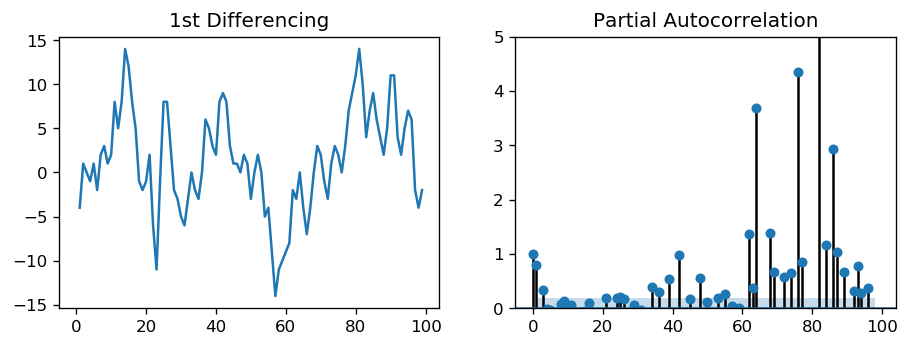

In [31]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But I am going to be conservative and tentatively fix the p as 1.

## How to find the order of the MA term (q)

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.

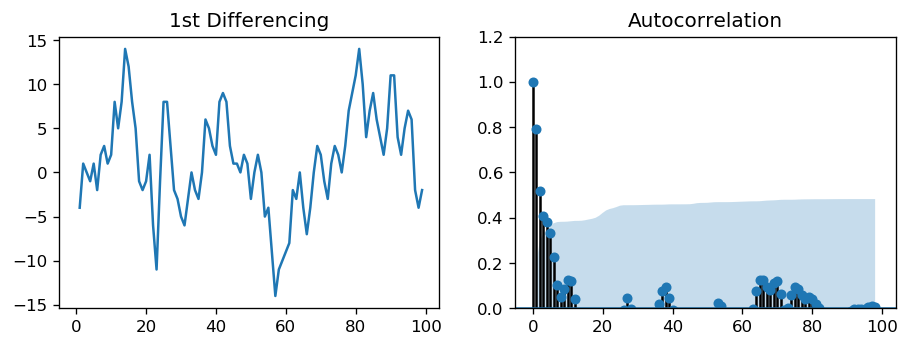

In [32]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

#df2 = pd.read_csv('../input/austa.csv')

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 2. When in doubt, go with the simpler model that sufficiently explains the Y.

## How to handle if a time series is slightly under or over differenced

It may so happen that your series is slightly under differenced, that differencing it one more time makes it slightly over-differenced.

How to handle this case?

If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

## How to build the ARIMA Model

Now that you’ve determined the values of p, d and q, you have everything needed to fit the ARIMA model.

Let’s use the ARIMA() implementation in statsmodels package.

In [33]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Mon, 26 Aug 2019   AIC                            517.579
Time:                        21:22:19   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.387      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.015       0.131       1.139
ma.L1.D.value     0.5287      0.355     

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

So, let’s rebuild the model without the MA2 term.

In [34]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Mon, 26 Aug 2019   AIC                            515.579
Time:                        21:22:20   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.386      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

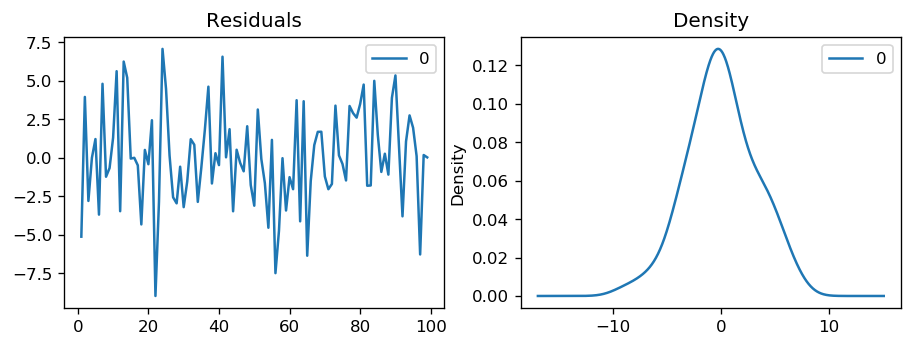

In [35]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance.

Let’s plot the actuals against the fitted values using plot_predict().

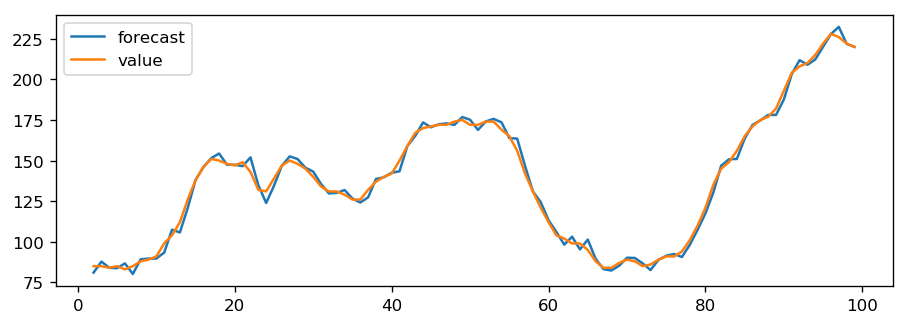

In [36]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

When you set dynamic=False the in-sample lagged values are used for prediction.

That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

So, we seem to have a decent ARIMA model. But is that the best?

Can’t say that at this point because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

So, the real validation you need now is the Out-of-Time cross-validation.

## How to do find the optimal ARIMA model manually using Out-of-Time Cross validation

In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

Why am I not sampling the training data randomly you ask?

That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [37]:
# Create Training and Test
train = df.value[:85]
test = df.value[85:]

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -216.887
Method:                       css-mle   S.D. of innovations              3.174
Date:                Mon, 26 Aug 2019   AIC                            441.775
Time:                        21:22:25   BIC                            451.498
Sample:                             1   HQIC                           445.683
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8435      1.446      0.583      0.561      -1.991       3.678
ar.L1.D.value     0.6528      0.095      6.899      0.000       0.467       0.838
ma.L1.D.value     0.4877      0.106     

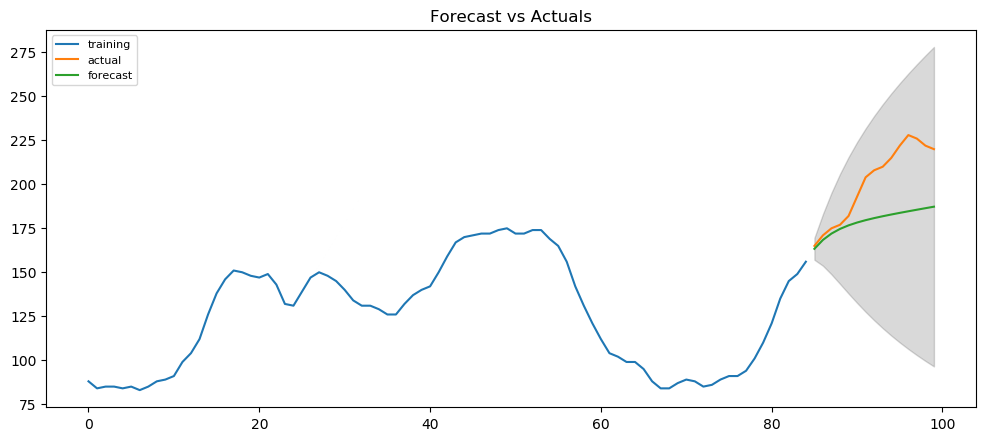

In [38]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But each of the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

So, what I am going to do is to increase the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

While doing this, I keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05.

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Mon, 26 Aug 2019   AIC                            440.497
Time:                        21:22:33   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0483      0.084      0.577      0.565      -0.116       0.212
ar.L1.D2.value     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.value    -0.5923      0.155

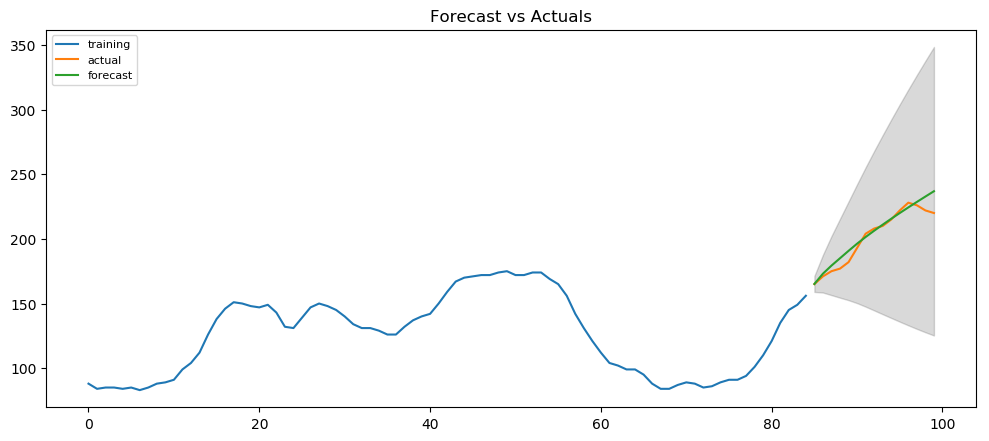

In [39]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The AIC has reduced to 440 from 515. Good. The P-values of the X terms are less the < 0.05, which is great.

So overall it’s much better.

Ideally, you should go back multiple points in time, like, go back 1, 2, 3 and 4 quarters and see how your forecasts are performing at various points in the year.

Here’s a great practice exercise: Try to go back 27, 30, 33, 36 data points and see how the forcasts performs. The forecast performance can be judged using various accuracy metrics discussed next.

## Accuracy Metrics for Time Series Forecast

The commonly used accuracy metrics to judge forecasts are:

- Mean Absolute Percentage Error (MAPE)
- Mean Error (ME)
- Mean Absolute Error (MAE)
- Mean Percentage Error (MPE)
- Root Mean Squared Error (RMSE)
- Lag 1 Autocorrelation of Error (ACF1)
- Correlation between the Actual and the Forecast (corr)
- Min-Max Error (minmax)

Typically, if you are comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used.

Why not use the other metrics?

Because only the above three are percentage errors that vary between 0 and 1. That way, you can judge how good is the forecast irrespective of the scale of the series.

The other error metrics are quantities. That implies, an RMSE of 100 for a series whose mean is in 1000’s is better than an RMSE of 5 for series in 10’s. So, you can’t really use them to compare the forecasts of two different scaled time series.

In [41]:
from statsmodels.tsa.stattools import acf

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.022501380384791103,
 'me': 3.230821815939879,
 'mae': 4.548336128404448,
 'mpe': 0.016421182278133616,
 'rmse': 6.373264462713306,
 'acf1': 0.5105499188868172,
 'corr': 0.9674576276789928,
 'minmax': 0.021631606706307815}

Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.

Now you know how to build an ARIMA model manually.

But in industrial situations, you will be given a lot of time series to be forecasted and the forecasting exercise be repeated regularly.

So we need a way to automate the best model selection process.

## How to do Auto Arima Forecast in Python

Like R’s popular auto.arima() function, the pmdarima package provides auto_arima() with similar functionality.

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [42]:
from pmdarima import auto_arima

model = auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 2, 1); AIC=525.586, BIC=535.926, Fit time=0.481 seconds
Fit ARIMA: order=(0, 2, 0); AIC=533.474, BIC=538.644, Fit time=0.025 seconds
Fit ARIMA: order=(1, 2, 0); AIC=532.437, BIC=540.192, Fit time=0.147 seconds


/opt/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  strides[k] = zi.strides[k]
/opt/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  elif k != axis and zi.shape[k] == 1:
/opt/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

Fit ARIMA: order=(0, 2, 1); AIC=525.893, BIC=533.648, Fit time=0.148 seconds
Fit ARIMA: order=(2, 2, 1); AIC=515.248, BIC=528.173, Fit time=0.692 seconds
Fit ARIMA: order=(2, 2, 0); AIC=513.459, BIC=523.798, Fit time=0.228 seconds
Fit ARIMA: order=(3, 2, 1); AIC=512.552, BIC=528.062, Fit time=2.087 seconds
Fit ARIMA: order=(3, 2, 0); AIC=515.284, BIC=528.209, Fit time=0.499 seconds
Fit ARIMA: order=(3, 2, 2); AIC=514.514, BIC=532.609, Fit time=2.846 seconds
Total fit time: 7.942 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   98
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -250.276
Method:                       css-mle   S.D. of innovations              3.069
Date:                Mon, 26 Aug 2019   AIC                            512.552
Time:                        21:27:35   BIC                            528.062
Sample:                           

## How to interpret the residual plots in ARIMA model

Let’s review the residual plots using stepwise_fit.

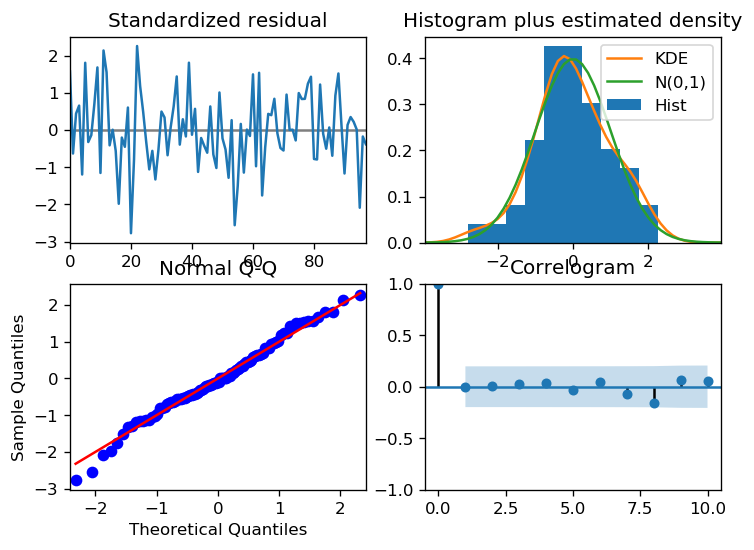

In [43]:
model.plot_diagnostics(figsize=(7,5))

plt.show()

So how to interpret the plot diagnostics?

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s forecast.

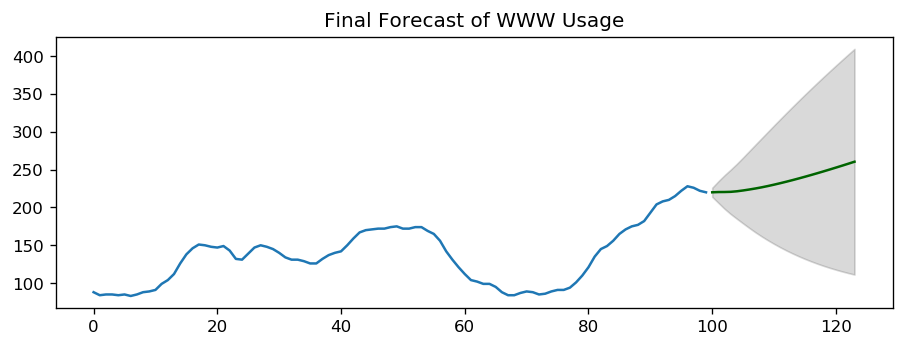

In [44]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

## How to automatically build SARIMA model in python

The problem with plain ARIMA model is it does not support seasonality.

If your time series has defined seasonality, then, go for SARIMA which uses seasonal differencing.

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

So, the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series.

If your model has well defined seasonal patterns, then enforce D=1 for a given frequency ‘x’.

Here’s some practical advice on building SARIMA model:

As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either SAR or SMA terms if your model has seasonal components.

In [52]:
# Import
data = pd.read_csv('../input/a10drugs.csv', parse_dates=['date'], index_col='date')
data.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


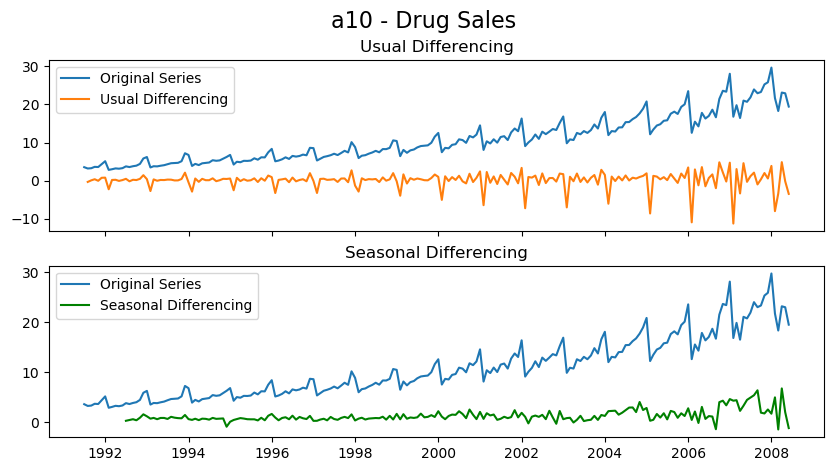

In [45]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

As you can clearly see, the seasonal spikes is intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing.

Let’s build the SARIMA model using pmdarima‘s auto_arima(). To do that, you need to set seasonal=True, set the frequency m=12 for month wise series and enforce D=1.

In [46]:
from pmdarima import auto_arima

# Seasonal - fit stepwise auto-ARIMA
smodel = auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=534.818, BIC=551.105, Fit time=16.241 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=624.061, BIC=630.576, Fit time=0.266 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=596.004, BIC=609.034, Fit time=6.368 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=611.475, BIC=624.505, Fit time=4.364 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=556.831, BIC=576.376, Fit time=28.646 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=559.407, BIC=572.437, Fit time=2.545 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=536.817, BIC=556.362, Fit time=49.904 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=529.829, BIC=549.374, Fit time=16.052 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(0, 1, 1, 12)   Log Likelihood                -258.300
Date:                            Mon, 26 Aug 2019   AIC                            528.601
Time:                                    21:44:54   BIC                            548.146
Sample:                                         0   HQIC                           536.517
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1649      0.097      1.705      0.088      -0.025       0.354
ar.L1          0.0949      0.043      2.205      0.027       0.011       0.179
ar.L2          0.4145      0.035     11.907      0.000       0.346       0.483
ar.L3          0.3531      0.053      6.601      0.000       0.248       0.458
ma.S.L12      -0.4635      0.058     -8.008      0.000      -0.577      -0.350
sigma2         0.8461      0.057     14.925      0.000       0.735       0.957
===================================================================================
Ljung-Box (Q):                       59.80   Jarque-Bera (JB):               124.59
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.75   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model has estimated the AIC and the P values of the coefficients look significant. Let’s look at the residual diagnostics plot.

The best model SARIMAX(3, 0, 0)x(0, 1, 1, 12) has an AIC of 528.6 and the P Values are significant.

Let’s forecast for the next 24 months.

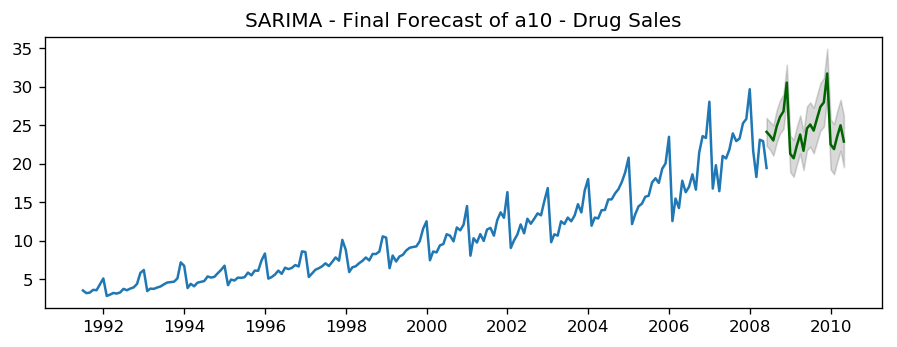

In [47]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

There you have a nice forecast that captures the expected seasonal demand pattern.

## How to build SARIMAX Model with exogenous variable

The SARIMA model we built is good. I would stop here typically.

But for the sake of completeness, let’s try and force an external predictor, also called, ‘exogenous variable’ into the model. This model is called the SARIMAX model.

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

For the sake of demonstration, I am going to use the seasonal index from the classical seasonal decomposition on the latest 36 months of data.

Why the seasonal index? Isn’t SARIMA already modeling the seasonality, you ask?

You are correct.

But also, I want to see how the model looks if we force the recent seasonality pattern into the training and forecast.

Secondly, this is a good variable for demo purpose. So you can use this as a template and plug in any of your variables into the code. The seasonal index is a good exogenous variable because it repeats every frequency cycle, 12 months in this case.

So, you will always know what values the seasonal index will hold for the future forecasts.

Let’s compute the seasonal index so that it can be forced as a (exogenous) predictor to the SARIMAX model.

In [48]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df3 = pd.merge(data, seasonal_index, how='left', on='month')
df3.columns = ['value', 'month', 'seasonal_index']
df3.index = data.index  # reassign the index

In [49]:
df3.head()

,value,month,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141


The exogenous variable (seasonal index) is ready. Let’s build the SARIMAX model.

In [50]:
# SARIMAX Model
sxmodel = auto_arima(df3[['value']], exogenous=df3[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=536.818, BIC=556.362, Fit time=27.804 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=626.061, BIC=635.834, Fit time=0.335 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=598.004, BIC=614.292, Fit time=15.525 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=613.475, BIC=629.762, Fit time=6.500 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=559.176, BIC=581.979, Fit time=46.238 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=561.407, BIC=577.695, Fit time=3.065 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=538.817, BIC=561.620, Fit time=65.841 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=531.829, BIC=554.632, Fit time=19.097 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(0, 1, 1, 12)   Log Likelihood                -258.300
Date:                            Mon, 26 Aug 2019   AIC                            530.601
Time:                                    21:59:03   BIC                            553.403
Sample:                                         0   HQIC                           539.836
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1649      0.097      1.705      0.088      -0.025       0.354
x1          3.932e-07   2.41e-09    162.886      0.000    3.88e-07    3.98e-07
ar.L1          0.0949      0.043      2.205      0.027       0.011       0.179
ar.L2          0.4145      0.035     11.907      0.000       0.346       0.483
ar.L3          0.3531      0.053      6.601      0.000       0.248       0.458
ma.S.L12      -0.4635      0.058     -8.008      0.000      -0.577      -0.350
sigma2         0.8461      0.057     14.925      0.000       0.735       0.957
===================================================================================
Ljung-Box (Q):                       59.80   Jarque-Bera (JB):               124.59
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.75   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+18. Standard errors may be unstable.
"""

So, we have the model with the exogenous term. But the coefficient is very small for x1, so the contribution from that variable will be negligible. Let’s forecast it anyway.

We have effectively forced the latest seasonal effect of the latest 3 years into the model instead of the entire history.

Alright let’s forecast into the next 24 months. For this, you need the value of the seasonal index for the next 24 months.

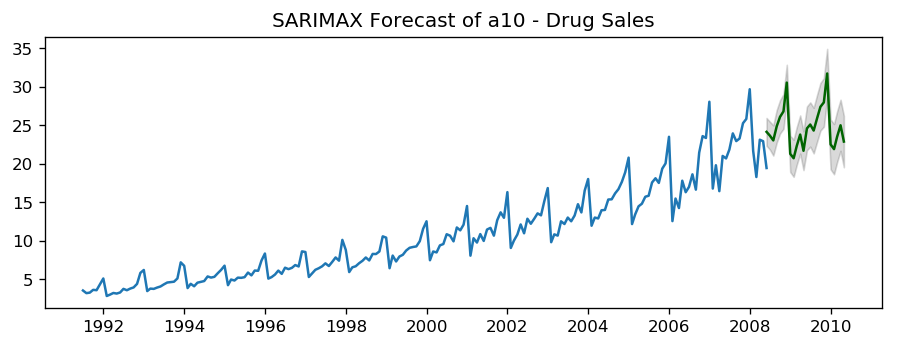

In [51]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

## Practice Exercises

In the AirPassengers dataset, go back 12 months in time and build the SARIMA forecast for the next 12 months.

- Is the series stationary? If not what sort of differencing is required?
- What is the order of your best model?
- What is the AIC of your model?
- What is the MAPE achieved in OOT cross-validation?
- What is the order of the best model predicted by auto_arima() method?

## Conclusion

We have covered a lot of concepts starting from the very basics of forecasting, AR, MA, ARIMA, SARIMA and finally the SARIMAX model.